In [1]:
import os
import re
import numpy as np 
import pandas as pd
import tensorflow as tf
from tqdm.notebook import tqdm
from keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

In [2]:
home_dir = '/kaggle/input/utkface-new/UTKFace'

# Modelo a ser utilizado
cnn_modelo = "cnn_tcc_will"  # Modelos disponíveis: InceptionV3, MobileNetV2, ResNet50, EfficientNetB0, cnn_tcc_will

EPOCHS = 50  # Limitado para não ultrapassar tempo do Kaggle

# Set the data generators
BATCH_SIZE=64

print(f"Versão do TensorFlow: {tf.__version__}")
print(f"Modelo Selecionado: {cnn_modelo}")

Versão do TensorFlow: 2.17.1
Modelo Selecionado: cnn_tcc_will


In [3]:
if cnn_modelo == "InceptionV3":
    from tensorflow.keras.applications import InceptionV3
    
elif cnn_modelo == "MobileNetV2":
    from tensorflow.keras.applications import MobileNetV2
    
elif cnn_modelo == "ResNet50":
    from tensorflow.keras.applications import ResNet50
    
elif cnn_modelo == "EfficientNetB0":
    from tensorflow.keras.applications import EfficientNetB0
elif cnn_modelo == "cnn_tcc_will":
    from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, BatchNormalization, GlobalAveragePooling2D
else:
    print(f"{cnn_modelo} não lib não localizada")

In [4]:
temp_lst = os.listdir(home_dir)
temp_lst[0]

'26_0_2_20170104023102422.jpg.chip.jpg'

In [5]:
full_paths = []
ages = []
genders = []

# Parse the directory
for filename in tqdm(os.listdir(home_dir)):
    age, gender = filename.split('_')[:2]
    # append all paths and labels
    full_paths.append(os.path.join(home_dir, filename))
    ages.append(int(age))
    genders.append(str(gender))  

  0%|          | 0/23708 [00:00<?, ?it/s]

In [6]:
# Create a DataFrame
data = pd.DataFrame({
    'path': full_paths,
    'age': ages,
    'gender': [str(g) for g in genders]  # Converter para string
})
data.head(10)

,path,age,gender
0,/kaggle/input/utkface-new/UTKFace/26_0_2_20170...,26,0
1,/kaggle/input/utkface-new/UTKFace/22_1_1_20170...,22,1
2,/kaggle/input/utkface-new/UTKFace/21_1_3_20170...,21,1
3,/kaggle/input/utkface-new/UTKFace/28_0_0_20170...,28,0
4,/kaggle/input/utkface-new/UTKFace/17_1_4_20170...,17,1
5,/kaggle/input/utkface-new/UTKFace/44_0_3_20170...,44,0
6,/kaggle/input/utkface-new/UTKFace/35_0_2_20170...,35,0
7,/kaggle/input/utkface-new/UTKFace/76_0_0_20170...,76,0
8,/kaggle/input/utkface-new/UTKFace/36_1_0_20170...,36,1
9,/kaggle/input/utkface-new/UTKFace/34_0_3_20170...,34,0


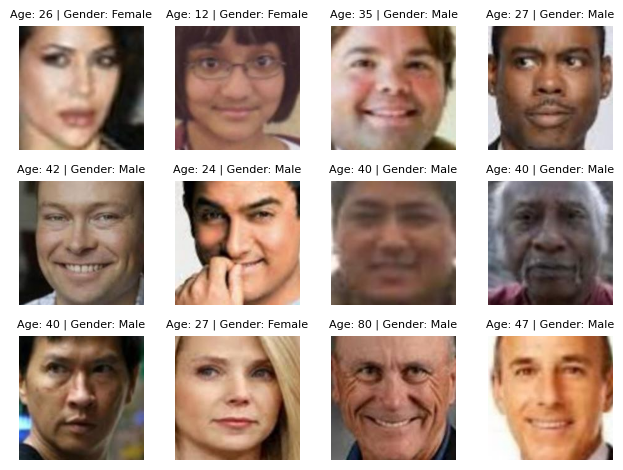

In [7]:
# Display 12 random images
data_sample = data.sample(12).reset_index(drop=True)
       
for i in range(0, 12):
    path = data_sample.loc[i, 'path']
    age = data_sample.loc[i, 'age']
    gender = 'Male' if data_sample.loc[i, 'gender'] == "0" else 'Female'
    img = plt.imread(path)
    plt.subplot(3, 4, i+1)
    plt.imshow(img)
    plt.title(f'Age: {age} | Gender: {gender}', fontsize=8)
    plt.axis('off')
plt.tight_layout()

In [8]:
# Split the data to train, validation and split datasets 
X_train, X_test_val = train_test_split(data, test_size=0.2, random_state=7)

# Split test and val evenly
X_test, X_val = train_test_split(X_test_val, test_size=0.5, random_state=7)

In [9]:
class CustomDataGenerator(Sequence):
    def __init__(self, generator, workers=1, use_multiprocessing=False, max_queue_size=10, **kwargs):
        super().__init__(**kwargs)
        self.generator = generator
        self.workers = workers  # Armazena o valor de workers
        self.use_multiprocessing = use_multiprocessing  # Armazena o valor de use_multiprocessing
        self.max_queue_size = max_queue_size  # Armazena o valor de max_queue_size

    def __len__(self):
        return len(self.generator)

    def __getitem__(self, index):
        images, labels = self.generator[index]
        return images, {'gender_out': labels}

    def on_epoch_end(self):
        self.generator.on_epoch_end()

In [10]:
datagen_train = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.9, 1.25],
    fill_mode='nearest'
)

datagen_val_test = ImageDataGenerator(rescale=1/255.)

train_generator = CustomDataGenerator(
    datagen_train.flow_from_dataframe(  # flow_from_dataframe *dentro* do CustomDataGenerator
        dataframe=X_train,
        x_col='path',
        y_col='gender',
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        class_mode='binary'
    ),
    workers=4,  # Passe os argumentos workers, use_multiprocessing e max_queue_size AQUI
    use_multiprocessing=True,
    max_queue_size=20
)

val_generator = CustomDataGenerator(
    datagen_val_test.flow_from_dataframe(  # flow_from_dataframe *dentro* do CustomDataGenerator
        dataframe=X_val,
        x_col='path',
        y_col='gender',
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        class_mode='binary'
    ),
    workers=4,  # Passe os argumentos workers, use_multiprocessing e max_queue_size AQUI
    use_multiprocessing=True,
    max_queue_size=20
)

test_generator = CustomDataGenerator(
    datagen_val_test.flow_from_dataframe(  # flow_from_dataframe *dentro* do CustomDataGenerator
        dataframe=X_test,
        x_col='path',
        y_col='gender',
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        class_mode='binary'
    ),
    workers=4,  # Passe os argumentos workers, use_multiprocessing e max_queue_size AQUI
    use_multiprocessing=True,
    max_queue_size=20
)

Found 18966 validated image filenames belonging to 2 classes.
Found 2371 validated image filenames belonging to 2 classes.
Found 2371 validated image filenames belonging to 2 classes.


In [11]:
model = None

if cnn_modelo == "InceptionV3":
    base = InceptionV3(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    for layer in base.layers[:136]:
        layer.trainable = False
    for layer in base.layers[136:]:
        layer.trainable = True

elif cnn_modelo == "MobileNetV2":
    base = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    for layer in base.layers[:100]:
        layer.trainable = False
    for layer in base.layers[100:]:
        layer.trainable = True

elif cnn_modelo == "ResNet50":
    base = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    for layer in base.layers[:150]:
        layer.trainable = False
    for layer in base.layers[150:]:
        layer.trainable = True

elif cnn_modelo == "EfficientNetB0":
    base = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    for layer in base.layers[:200]:
        layer.trainable = False
    for layer in base.layers[200:]:
        layer.trainable = True

elif cnn_modelo == "cnn_tcc_will":
    inputs = tf.keras.Input(shape=(224, 224, 3))

    # Primeira camada convolucional
    x = Conv2D(32, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)  # Normalização antes da ativação
    x = tf.keras.layers.ReLU()(x)
    x = MaxPooling2D((2, 2))(x)

    # Segunda camada convolucional
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)  # Normalização antes da ativação
    x = tf.keras.layers.ReLU()(x)
    x = MaxPooling2D((2, 2))(x)

    # Terceira camada convolucional
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)  # Normalização antes da ativação
    x = tf.keras.layers.ReLU()(x)
    x = MaxPooling2D((2, 2))(x)

    # Global Average Pooling e Camadas Fully Connected
    x = GlobalAveragePooling2D()(x)
    x = Dense(512)(x)
    x = BatchNormalization()(x)  # Normalização antes da ativação
    x = tf.keras.layers.ReLU()(x)
    x = Dropout(0.5)(x)
    
    # Camada de saída para gênero
    gender_out = Dense(1, activation='sigmoid', name='gender_out')(x)

    # Criando o modelo final
    model = Model(inputs=inputs, outputs=gender_out)
    model.summary()

else:
    print(f"Modelo {cnn_modelo} não suportado")
    model = None

if cnn_modelo != "cnn_tcc_will" and model is None:
    # Adicionando a camada de pooling global
    x = base.output
    x = GlobalAveragePooling2D()(x)

    # Branch para gênero (binário)
    gender_branch = Dense(512, activation='relu')(x)
    gender_branch = Dropout(0.5)(gender_branch)
    gender_out = Dense(1, activation='sigmoid', name='gender_out')(gender_branch)

    # Criando o modelo final
    model = Model(inputs=base.input, outputs=gender_out)
    model.summary()


#base = InceptionV3(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

#for layer in base.layers[:136]:
#    layer.trainable = False
#for layer in base.layers[136:]:
#    layer.trainable = True

#x = base.output
#x = GlobalAveragePooling2D()(x)

# Branch único para gênero
#gender_branch = Dense(512, activation='relu')(x)
#gender_branch = Dropout(0.5)(gender_branch)
#gender_out = Dense(1, activation='sigmoid', name='gender_out')(gender_branch)

#model = Model(inputs=base.input, outputs=gender_out)  # <--- Saída única
#model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gender_out (Dense)                   │ (None, 1)                   │             5

 Total params: 162,753 (635.75 KB)

 Trainable params: 161,281 (630.00 KB)

 Non-trainable params: 1,472 (5.75 KB)

In [12]:
# Add callbacks and optimiser 
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  
    factor=0.5,          
    patience=5,          
    min_lr=0.00001,      
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=10,         
    verbose=1,
    restore_best_weights=True
)
    
adam = Adam(learning_rate=0.001)

In [ ]:
model.compile(optimizer=adam,
              loss={'gender_out': 'binary_crossentropy'},
              metrics={'gender_out': ['accuracy']})  # <--- Métrica simplificada

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 170s 504ms/step - accuracy: 0.5995 - loss: 0.7466 - val_accuracy: 0.5534 - val_loss: 0.6762 - learning_rate: 0.0010
Epoch 2/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 155s 508ms/step - accuracy: 0.6535 - loss: 0.6372 - val_accuracy: 0.5226 - val_loss: 0.7479 - learning_rate: 0.0010
Epoch 3/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 155s 510ms/step - accuracy: 0.7040 - loss: 0.5787 - val_accuracy: 0.6310 - val_loss: 0.6639 - learning_rate: 0.0010
Epoch 4/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 202s 509ms/step - accuracy: 0.7265 - loss: 0.5445 - val_accuracy: 0.4960 - val_loss: 1.5248 - learning_rate: 0.0010
Epoch 5/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 156s 511ms/step - accuracy: 0.7379 - loss: 0.5202 - val_accuracy: 0.7672 - val_loss: 0.4898 - learning_rate: 0.0010
Epoch 6/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 156s 511ms/step - accuracy: 0.7537 - loss: 0.4968 - val_accuracy: 0.6807 - val_loss: 0.5870 - learning_rate: 0.0010
Epoch 7/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 156s 511ms/step - accura

In [ ]:
# Salvar modelo nos dois formatos
model.save(f"{cnn_modelo}_gender_classifier.h5")
model.save(f"{cnn_modelo}_gender_classifier.keras")
print("Modelo salvo em HDF5 (.h5) e formato Keras (.keras)!")

# Criando um DataFrame com as métricas
df = pd.DataFrame(history.history)
nome_arquivo = f"history_{cnn_modelo}_humor.csv"
df.to_csv(nome_arquivo, index=False)
print(f"Histórico salvo em {nome_arquivo}")

In [ ]:
print(history.history.keys())


In [ ]:
fig = plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Evolution')
plt.grid(True)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy Evolution')
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
fig = plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Evolution')
plt.grid(True)

# Verificar a chave exata de acurácia no histórico do treinamento
accuracy_key = 'gender_out_accuracy' if 'gender_out_accuracy' in history.history else 'accuracy'
val_accuracy_key = 'val_gender_out_accuracy' if 'val_gender_out_accuracy' in history.history else 'val_accuracy'

# Acurácia
plt.subplot(1, 2, 2)
plt.plot(history.history[accuracy_key], label='Train Accuracy')
plt.plot(history.history[val_accuracy_key], label='Val Accuracy')
plt.legend()
plt.title('Accuracy Evolution')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
best_val_accuracy = max(history.history['val_accuracy']) * 100
print(f"Melhor acurácia de validação: {best_val_accuracy:.2f}%")

last_epoch_val_accuracy = history.history['val_accuracy'][-1] * 100
print(f"Acurácia de validação na última época: {last_epoch_val_accuracy:.2f}%")



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Carregar o modelo salvo
model = load_model(f"/kaggle/working/{cnn_modelo}_gender_classifier.h5")

# Selecionar 12 imagens aleatórias do dataset
sample_images = random.sample(full_paths, 12)

plt.figure(figsize=(15, 12))

for i, img_path in enumerate(sample_images):
    # Obter o rótulo real a partir do nome da imagem
    filename = img_path.split('/')[-1]
    real_age, real_gender = filename.split('_')[:2]
    real_gender = "Male" if int(real_gender) == 0 else "Female"

    # Carregar e pré-processar a imagem
    img = image.load_img(img_path, target_size=(224, 224), color_mode="rgb")
    img_array = image.img_to_array(img) / 255.0  
    img_array = np.expand_dims(img_array, axis=0)

    # Fazer a previsão
    pred = model.predict(img_array)[0][0]  # Pegar a previsão da saída única
    pred_gender = "Male" if pred < 0.5 else "Female"

    # Plotar a imagem
    plt.subplot(3, 4, i+1)
    plt.imshow(img)
    plt.title(f"Real: {real_gender} | Pred: {pred_gender}", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()